In [1]:
%pip install prophet statsmodels scikit-learn keras tensorflow matplotlib pandas numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 779.2 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 373.6 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 991.0/991.0 kB 474.3 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import timedelta




In [16]:
# Convert to datetime and extract just the date
df['DateTime'] = pd.to_datetime(df['DateTime']).dt.date

# Keep the last record of each day
daily_df = df.groupby('DateTime').last().reset_index()

# Save the cleaned data
daily_df.to_csv('cleaned_stock_data.csv', index=False)

# Display the cleaned DataFrame and min/max values
print(daily_df)
print("Min value of BTCL stock:", daily_df.min())
print("Max value of BTCL stock:", daily_df.max())


        DateTime    BTCL         ds
0     2020-04-23  158.45 2020-04-23
1     2020-04-24  158.45 2020-04-24
2     2020-04-27  158.45 2020-04-27
3     2020-04-28  158.45 2020-04-28
4     2020-04-29  158.45 2020-04-29
...          ...     ...        ...
1225  2025-04-21  570.00 2025-04-21
1226  2025-04-22  570.00 2025-04-22
1227  2025-04-23  570.00 2025-04-23
1228  2025-04-24  570.00 2025-04-24
1229  2025-04-25  570.00 2025-04-25

[1230 rows x 3 columns]
Min value of BTCL stock: DateTime             2020-04-23
BTCL                       40.0
ds          2020-04-23 00:00:00
dtype: object
Max value of BTCL stock: DateTime             2025-04-25
BTCL                    1178.57
ds          2025-04-25 00:00:00
dtype: object


In [18]:

# Convert DateTime column to datetime type 
daily_df['DateTime'] = pd.to_datetime(daily_df['DateTime'])

# Create interactive plot
fig = px.line(daily_df, 
              x='DateTime', 
              y='BTCL',
              title='BTCL Price Over Time',
              labels={'BTCL': 'Price (Ngultrum)', 'DateTime': 'Date'},
              template='plotly_white')

# Add customization
fig.update_layout(
    hovermode='y unified',  # Show hover data for all points on x-axis
    xaxis_title='Date',
    yaxis_title='BTCL Price (Ngultrum)',
    
    xaxis_rangeslider_visible=True  # Adds zoom slider at bottom
)

# Add hover data formatting
fig.update_traces(
    hovertemplate='<b>%{x|%Y-%m-%d}</b><br>Price: Nu.%{y:.2f}'
)

# Show the plot
fig.show()

17:48:37 - cmdstanpy - INFO - Chain [1] start processing
17:48:38 - cmdstanpy - INFO - Chain [1] done processing


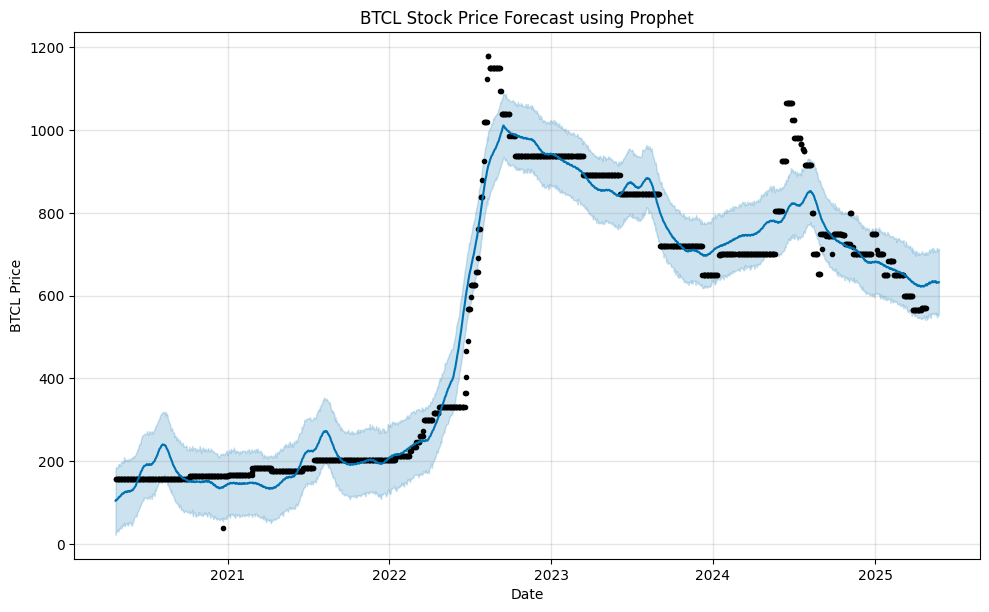

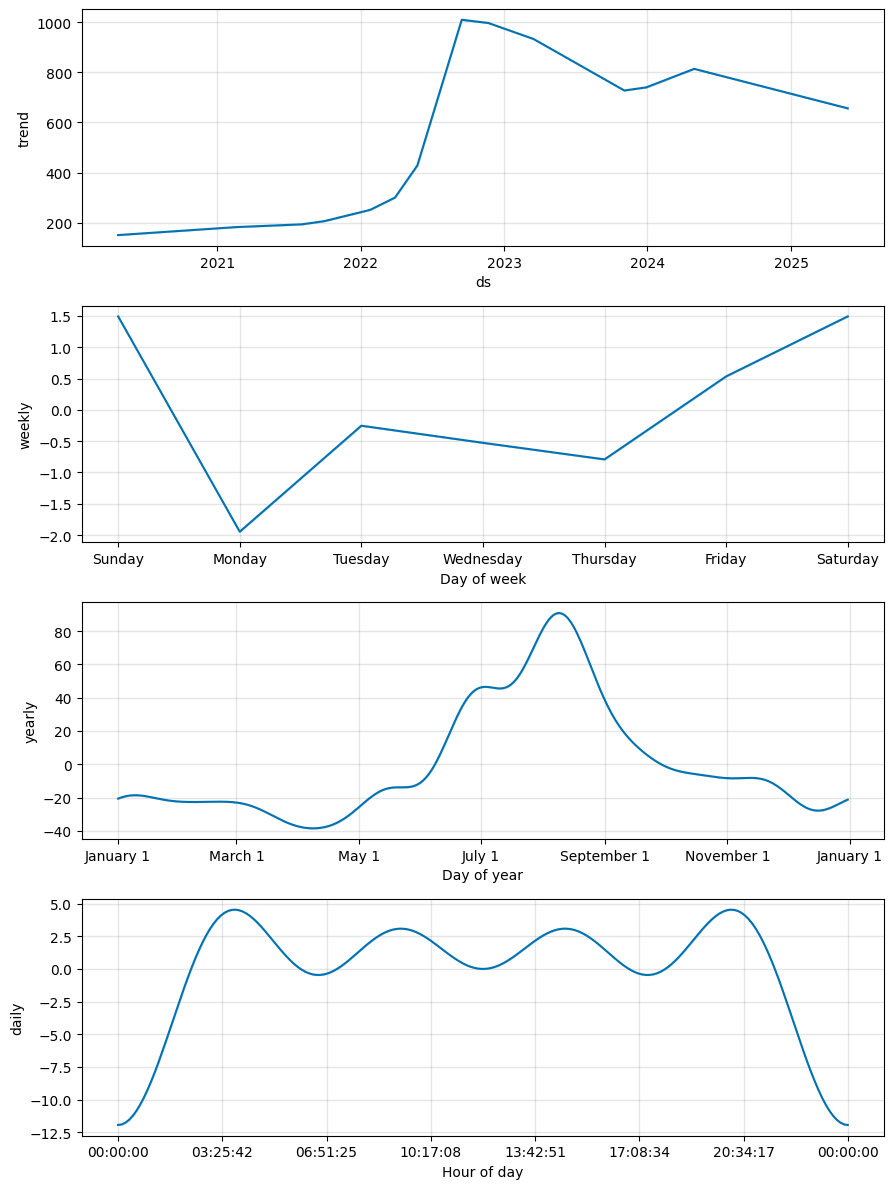

In [19]:
# Prophet expects columns 'ds' for date and 'y' for target
# Create a temporary DataFrame with correct column names for Prophet
prophet_df = pd.DataFrame()
prophet_df['ds'] = daily_df['DateTime']
prophet_df['y'] = daily_df['BTCL']

# Initialize and fit the Prophet model
model = Prophet(daily_seasonality=True)
model.fit(prophet_df)

# Create future dataframe for the next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
plt.title("BTCL Stock Price Forecast using Prophet")
plt.xlabel("Date")
plt.ylabel("BTCL Price")
plt.grid(True)
plt.show()

# Optional: Plot forecast components (trend, seasonality)
fig2 = model.plot_components(forecast)
plt.show()

In [20]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30))


             ds        yhat  yhat_lower  yhat_upper
1230 2025-04-26  626.954537  549.837061  705.692865
1231 2025-04-27  627.466529  550.758037  698.644053
1232 2025-04-28  624.577027  541.998270  700.687478
1233 2025-04-29  626.853597  543.317456  704.112677
1234 2025-04-30  627.188862  552.047838  699.793334
1235 2025-05-01  627.550401  546.088453  702.741647
1236 2025-05-02  629.511522  550.562334  705.284861
1237 2025-05-03  631.105750  556.463275  710.837452
1238 2025-05-04  631.731298  555.062830  711.173383
1239 2025-05-05  628.897097  550.173339  704.197932
1240 2025-05-06  631.166795  553.326916  706.846264
1241 2025-05-07  631.430196  545.600214  708.147433
1242 2025-05-08  631.653328  555.494191  712.793994
1243 2025-05-09  633.409391  558.297444  712.473533
1244 2025-05-10  634.733353  556.866288  712.250927
1245 2025-05-11  635.026527  557.478009  715.874440
1246 2025-05-12  631.802648  556.600590  704.193572
1247 2025-05-13  633.631882  556.564166  713.620579
1248 2025-05

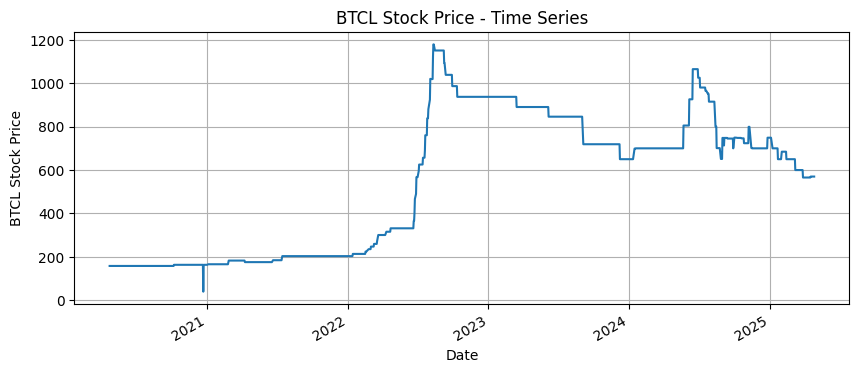

/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/ugyen/an

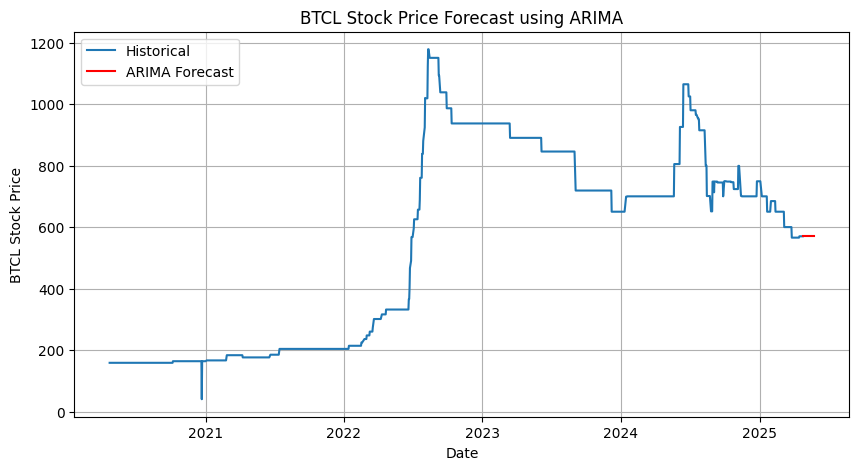

           Date  ARIMA_Predicted_BTCL
1230 2025-04-26                 570.0
1231 2025-04-27                 570.0
1232 2025-04-28                 570.0
1233 2025-04-29                 570.0
1234 2025-04-30                 570.0


In [21]:
daily_df.set_index('DateTime', inplace=True)

# Optional: Plot the time series
daily_df['BTCL'].plot(title='BTCL Stock Price - Time Series', figsize=(10, 4))
plt.xlabel("Date")
plt.ylabel("BTCL Stock Price")
plt.grid(True)
plt.show()

# --- STEP 1: Fit ARIMA Model (manual parameters or auto)
# Example: ARIMA(p=5, d=1, q=0) - You can tune these values
model = ARIMA(daily_df['BTCL'], order=(5, 1, 0))
model_fit = model.fit()

# --- STEP 2: Forecast Next 30 Days
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

# --- STEP 3: Create a date index for the forecast
last_date = daily_df.index[-1]
forecast_dates = [last_date + timedelta(days=i) for i in range(1, forecast_steps + 1)]

# --- STEP 4: Plot actual + forecast
plt.figure(figsize=(10, 5))
plt.plot(daily_df.index, daily_df['BTCL'], label='Historical')
plt.plot(forecast_dates, forecast, color='red', label='ARIMA Forecast')
plt.title("BTCL Stock Price Forecast using ARIMA")
plt.xlabel("Date")
plt.ylabel("BTCL Stock Price")
plt.legend()
plt.grid(True)
plt.show()

# --- Optional: Combine forecast with dates into DataFrame
forecast_df = pd.DataFrame({'Date': forecast_dates, 'ARIMA_Predicted_BTCL': forecast})
print(forecast_df.head())